<a href="https://colab.research.google.com/github/aaron-v19/practice/blob/main/pytorch_custom_datasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
#Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'


## 1.  Get Data

Our dataset is a subset of food101 dataset.

our dataset starts with 3 classes of 1000 images( 750 train, 250 test)



In [3]:
import requests
import zipfile
from pathlib import Path
# Setup a path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#if the image folder doesn't exist , download and prepare it

if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    print(f"Did not find {image_path}, creating one ....")
    image_path.mkdir(parents=True,exist_ok=True)

#Download pizza ,steak sushi
with open(data_path / "pizza_steak_sushi.zip","wb") as f:
    request= requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza,steak,sushi")
    f.write(request.content)

#unzip file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
    print("Unzipping pizza,steak and sushi data . . .")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi, creating one ....
Unzipping pizza,steak and sushi data . . .


In [4]:
# 2. Data preparation and data exploration
import os

def walk_through_dir(dir_path):
    for dirpath,dirnames,filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.


In [6]:
train_dir=image_path/ "train"
test_dir=image_path/"test"

In [7]:
image_path

PosixPath('data/pizza_steak_sushi')

data/pizza_steak_sushi/train/pizza/1649276.jpg
pizza
Image Class: pizza
Image height: 384
Image width: 512
Image format: JPEG


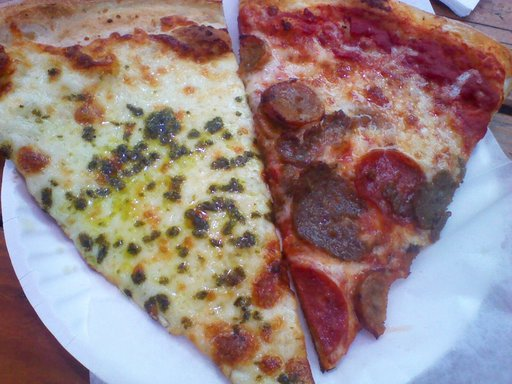

In [8]:
import random
from PIL import Image

#torch.manual_seed(42)

#1. Get all Image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))

#2. Pick a random image path
random_image_path=random.choice(image_path_list)
print(random_image_path)

#3. Get image class from path name
image_class=random_image_path.parent.stem
print(image_class)

#4. Print image
img=Image.open(random_image_path)

#5. print metadata
print(f"Image Class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
print(f"Image format: {img.format}")
img

#2. Visualize data

(-0.5, 511.5, 383.5, -0.5)

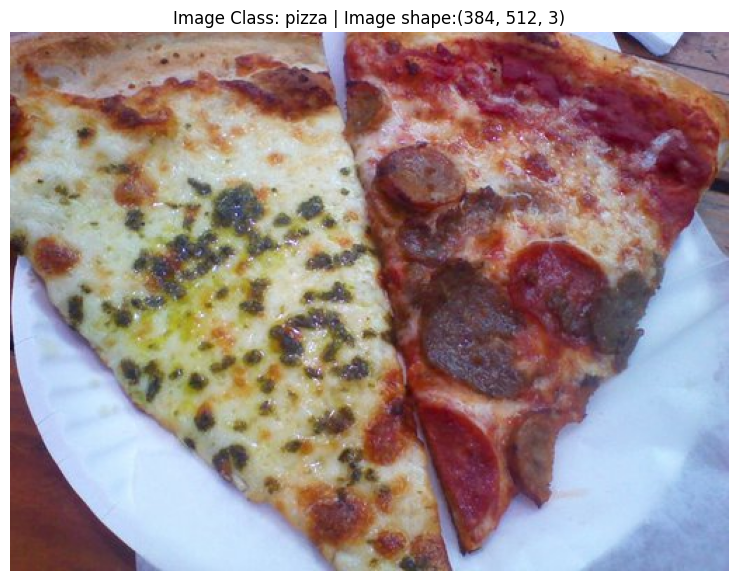

In [9]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array=np.asarray(img)

#Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image shape:{img_as_array.shape}")
plt.axis(False)

## 3.Transformig Data
 * Turn your data into tensors
 * Turn  it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

In [10]:
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

###3.1 Transforming data with`torchvision.transforms`
Transforms help you get your image get ready to be used with a model/perform data augmentation

In [11]:
#Write a transform for image
data_transform=transforms.Compose([
    #Resize our image to 64x64
    transforms.Resize(size=(64,64)),
    #Flip the images on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn the image into torch tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img).shape

torch.Size([3, 64, 64])

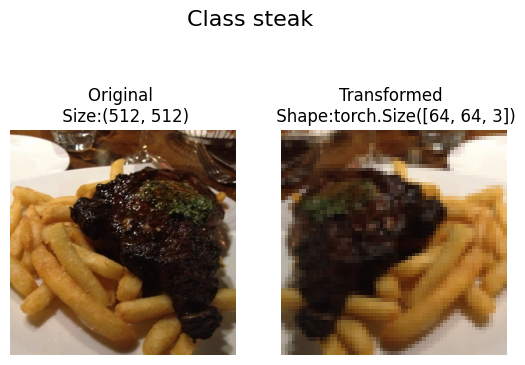

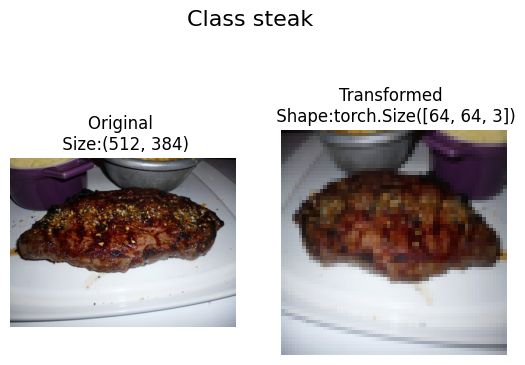

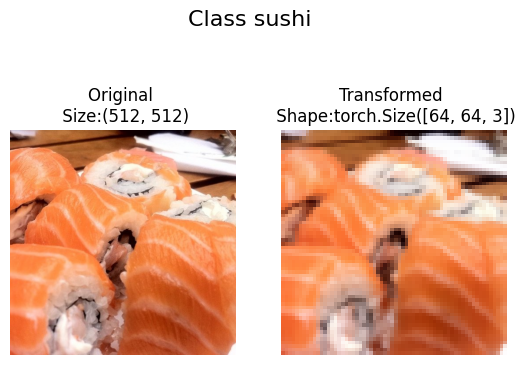

In [24]:
def plot_transformed_images(image_paths,transforms,n=3,seed=42):
    """
    Select a random image from a path of images and load /transforms
    them then plot the original vs transformed images
    """
    if seed:
        random.seed(seed)
    random_image_path=random.sample(image_paths,k=n)

    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig,ax=plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \n Size:{f.size}")
            ax[0].axis("off")

            # Transform and plot target image
            transformed_image=transforms(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \n Shape:{transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_path_list,data_transform,seed=42)

## 4. Option 1: Loading  Image data using ImageFolder
we can use `torchvision.datasets.ImageFolder` to load our data

In [26]:
from torchvision import datasets
train_data=datasets.ImageFolder(root=train_dir,
                    transform=data_transform,
                    target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                   transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [27]:
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [28]:
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [29]:
len(train_data),len(test_data)

(225, 75)

In [35]:
img,label=train_data[0]
print(f" Image Tensor: {img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Label: {label} ({class_names[label]})")
print(f"Label type: {type(label)}")

 Image Tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

 Original Shape:torch.Size([3, 64, 64])
 Permuted Shape:torch.Size([64, 64, 3])


Text(0.5, 1.0, 'Image Class: pizza')

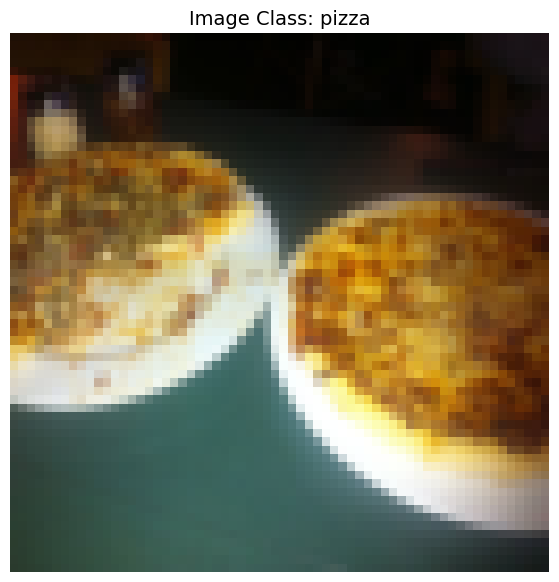

In [39]:
img_permute=img.permute(1,2,0)
img_permute.shape

print(f" Original Shape:{img.shape}")
print(f" Permuted Shape:{img_permute.shape}")

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(f"Image Class: {class_names[label]}", fontsize=14)

## 4.1 Turn loaded data images into `DataLoader`'s

A `DataLoader` is f=going to help us convert `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [46]:
# turn train and test datasets into dataloader

from torch.utils.data import DataLoader
import os
BATCH_SIZE=1

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=True
                            )

test_dataloader=DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=False
                            )

train_dataloader,test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x78252469a260>,
 <torch.utils.data.dataloader.DataLoader at 0x78252469bb50>)

In [47]:
len(train_dataloader),len(test_dataloader)

(225, 75)

In [48]:
img,label=next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


##5 Option 2: Loading Image Data with a Custom `Dataset`

*1. Want to be able to load image from file
*2. want ot be able to get class names from datasets
*3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
*Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything , it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing code, which could be prone to errors and performance issues

In [50]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

In [51]:
# Instance of torchvision.dataset.ImageFolder()

train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})